# Import des librairies nécessaires 

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from utils import *

In [12]:
sns.set_style("white")
sns.set_palette(sns.color_palette("pastel"))

# Sommaire

1. Partition
2. Best features selection
3. KNN
4. LDA, QDA, NB
5. Logistic regression
6. Decision trees

## Partition

In [13]:
data = pd.read_csv("fetal_health.csv")
data.fetal_health = pd.Categorical(data.fetal_health, categories=[1.0, 2.0, 3.0], ordered=True)

In [14]:
# Création de deux DF (un de labels et un de données)
labels = data.fetal_health
features = data.drop('fetal_health', axis=1)
print(features.shape)
print(labels.shape)

(2126, 21)
(2126,)


Les dimensions sont cohérentes

In [15]:
data_train, data_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=123, shuffle=True, stratify=labels)

print(data_train.shape, labels_train.shape)
print(data_test.shape, labels_test.shape)

(1700, 21) (1700,)
(426, 21) (426,)


Création d'une partition des données avec une proportion 80/20, random state spécifié pour avoir la même partition à chauqe appel, stratify= labels pour conserver les proportions de nos labels 

## Best features selection

In [16]:
#correlation_df = data.corr()[['fetal_health']].drop('fetal_health')

# Heatmap plot
plt.figure(figsize=(3, 5))
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True)
plt.title('Corrélation entre chaque variable et fetal_health')
plt.show()

NameError: name 'correlation_df' is not defined

<Figure size 300x500 with 0 Axes>

On remarque que les variables "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" et "mean_value_of_long_term_variability" sont celles qui sont le plus corrélé  à la santé du foetus

Nous allons regarder avec d'autres méthodes si ce sont les best features à utiliser

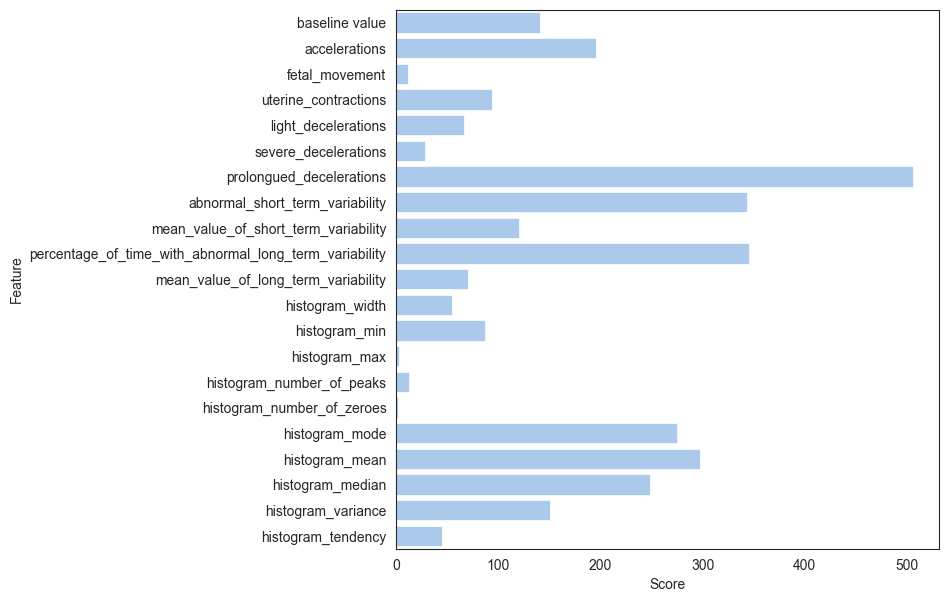

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

X = features
Y = labels

# f_classif correspond a un test d'ANOVA
best_features = SelectKBest(score_func=f_classif, k='all')

fit = best_features.fit(X,Y)

# résultats 
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

feature_scores = pd.concat([df_columns,df_scores],axis=1)
feature_scores.columns = ['Feature','Score'] 

#Visualize the feature scores
fig, ax=plt.subplots(figsize=(7,7))
plot=sns.barplot(data=feature_scores, x='Score', y='Feature',linewidth=0.5, orient='h')


En faisant ce test nous réalisons une analyse de la variance entre chaque variable et nos labels. Avec cela nous calculons un score qui montre les variables qui ont eu le meilleur "score" sur le test.

In [18]:
# On sélectionne les variables avec un score >= 200
selection = list(feature_scores[feature_scores['Score']>=200]['Feature'])
selection.append('fetal_health')

# On crée un nouveau dataset avec les variables qui nous intéressent
data_selected = data[selection]
data_selected.head()

,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_mode,histogram_mean,histogram_median,fetal_health
0,0.0,73.0,43.0,120.0,137.0,121.0,2.0
1,0.0,17.0,0.0,141.0,136.0,140.0,1.0
2,0.0,16.0,0.0,141.0,135.0,138.0,1.0
3,0.0,16.0,0.0,137.0,134.0,137.0,1.0
4,0.0,16.0,0.0,137.0,136.0,138.0,1.0


In [ ]:
#score_features = featureScores[featureScores['Score']>=200]

In [ ]:
#score_features

On voit que les variables sélectionnées sont en parties communes à celles montrées auparavant

In [19]:
# Création de deux DF
labels_selected = data_selected.fetal_health
features_selected = data_selected.drop('fetal_health', axis=1)

data_train_selected, data_test_selected, labels_train_selected, labels_test_selected = train_test_split(features_selected, labels_selected, test_size=0.2, random_state=123, shuffle=True, stratify=labels_selected)


# Création d'un dataframe pour stocker les résultats

In [20]:
accuracies_dataframe = pd.DataFrame(columns=['Algorithm', 'FeatureSelection', 'Standardization', 'Costs', 'Acc_train', 'Acc_test', 'Recall_Pathologic', 'Pathological predicted as Pathological or Suspect'])

def update_line(
        dataframe, 
        algorithm, 
        feature_selection, 
        standardization, 
        costs, 
        acc_train, 
        acc_test, 
        recall_pathologic, 
        patho_suspect
):
    # Rechercher les lignes correspondant à la clé primaire
    index_lignes = dataframe.loc[(dataframe['Algorithm'] == algorithm) &
                                   (dataframe['FeatureSelection'] == feature_selection) &
                                   (dataframe['Standardization'] == standardization) &
                                   (dataframe['Costs'] == costs)].index

    # Si la clé primaire n'existe pas, ajouter une nouvelle ligne
    if len(index_lignes) == 0:
        nouvelle_ligne = pd.DataFrame({
            'Algorithm': [algorithm],
            'FeatureSelection': [feature_selection],
            'Standardization': [standardization],
            'Costs':[costs],
            'Acc_train': [acc_train],
            'Acc_test': [acc_test],
            'Recall_Pathologic': [recall_pathologic],
            'Pathological predicted as Pathological or Suspect': [patho_suspect]
        })
        dataframe = pd.concat([dataframe, nouvelle_ligne], ignore_index=True)

    # Sinon, mettre à jour les valeurs existantes
    else:
        index_ligne = index_lignes[0]
        dataframe.loc[index_ligne, 'Acc_train'] = acc_train
        dataframe.loc[index_ligne, 'Acc_test'] = acc_test
        dataframe.loc[index_ligne, 'Recall_Pathologic'] = recall_pathologic
        dataframe.loc[index_ligne, 'Pathological predicted as Pathological or Suspect'] = patho_suspect

    return dataframe


## KNeighbors (sans selection des var)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

### Sélection du Kopt

In [22]:
n_folds = 10
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))

gen = knn_cross_validation2(data_train, labels_train, n_folds, n_neighbors_list)
df = pd.DataFrame(gen, columns=["# neighbors", "accuracy"])
df

,# neighbors,accuracy
0,1,"[0.9058823529411765, 0.8647058823529412, 0.882..."
1,2,"[0.888235294117647, 0.8647058823529412, 0.9, 0..."
2,3,"[0.9, 0.8588235294117647, 0.9, 0.8764705882352..."
3,4,"[0.9, 0.8705882352941177, 0.888235294117647, 0..."
4,5,"[0.9, 0.8705882352941177, 0.888235294117647, 0..."
...,...,...
66,389,"[0.7705882352941177, 0.7411764705882353, 0.794..."
67,414,"[0.7705882352941177, 0.7411764705882353, 0.794..."
68,441,"[0.7705882352941177, 0.7411764705882353, 0.794..."
69,470,"[0.7705882352941177, 0.7411764705882353, 0.794..."


In [23]:
# Calculer l'accuracy moyenne pour chaque ligne
df['mean_accuracy'] = df['accuracy'].apply(lambda acc_list: sum(acc_list) / len(acc_list))

# Trouver le nombre de voisins avec l'accuracy moyenne maximale
max_mean_accuracy = df['mean_accuracy'].max()
best_n_neighbors = df.loc[df['mean_accuracy'] == max_mean_accuracy, '# neighbors'].values[0]

print(f"Le meilleur nombre de voisins est: {best_n_neighbors} avec une accuracy moyenne de: {max_mean_accuracy:.4f}")

Le meilleur nombre de voisins est: 7 avec une accuracy moyenne de: 0.8953


In [24]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(data_train, labels_train)
prediction = clf.predict(data_test)

In [ ]:
prediction

array([1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 1., 3., 1., 1., 1., 1., 2., 1., 3., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 3., 1., 1., 2., 1., 1.,
       1., 1., 1., 2., 1., 3., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 3., 1., 1., 3., 3., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 3., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 2., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 2., 1., 1., 3., 1., 2., 1., 3., 1., 2., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 3., 1.,
       1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1.,
       3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
       2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1.,
       1., 1., 1., 1., 2.

In [25]:
prediction = pd.Categorical(prediction, categories=[1.0, 2.0, 3.0], ordered=True)

In [26]:
print("Accuracy globale")
print(f"Accuracy données d'entrainements: {clf.score(data_train, labels_train)}")
print(f"Accuracy données de test: {clf.score(data_test, labels_test)}")

Accuracy globale
Accuracy données d'entrainements: 0.9188235294117647
Accuracy données de test: 0.8849765258215962


In [27]:
print("Accuracy pour les labels 3")
print(f"Score données d'entrainements: {clf.score(data_train[labels_train == 3], labels_train[labels_train == 3])}")
print(f"Score données de test: {clf.score(data_test[labels_test == 3], labels_test[labels_test == 3])}")

Accuracy pour les labels 3
Score données d'entrainements: 0.8156028368794326
Score données de test: 0.7428571428571429


In [28]:
print("Accuracy pour les labels 2")
print(f"Score données d'entrainements: {clf.score(data_train[labels_train == 2], labels_train[labels_train == 2])}")
print(f"Score données de test: {clf.score(data_test[labels_test == 2], labels_test[labels_test == 2])}")


Accuracy pour les labels 2
Score données d'entrainements: 0.6864406779661016
Score données de test: 0.559322033898305


In [29]:
print("Accuracy pour les labels 1")
print(f"Score données d'entrainements: {clf.score(data_train[labels_train == 1], labels_train[labels_train == 1])}")
print(f"Score données de test: {clf.score(data_test[labels_test == 1], labels_test[labels_test == 1])}")

Accuracy pour les labels 1
Score données d'entrainements: 0.9712773998488284
Score données de test: 0.9578313253012049


In [30]:
cm = confusion_matrix(labels_test, prediction)
cm

array([[318,  13,   1],
       [ 25,  33,   1],
       [  6,   3,  26]], dtype=int64)

In [31]:
report = classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'])
report_dict = classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)
print(report)

              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       332
     Suspect       0.67      0.56      0.61        59
  Pathologic       0.93      0.74      0.83        35

    accuracy                           0.88       426
   macro avg       0.84      0.75      0.79       426
weighted avg       0.88      0.88      0.88       426



In [32]:
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'Knn', 
    False, 
    False, 
    False, 
    clf.score(data_train, labels_train), 
    clf.score(data_test, labels_test), 
    report_dict['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571


On réalise donc un K plus proches voisins (k=5) sur l'ensemble d'entrainement et nous utilisons ce modèle (clf) pour prédire les data de tests. En calculant les scores (proportions de bonnes prédictions) nous avons 92% et 89% pour les prédictions de test. La prédiction est donc bonne et se généralise bien à de nouvelles données (pas d'overfitting). 

Par contre en regardant le score pour chaque classe, on remarque que celui-ci est très bon pour la classe 1 mais beaucoup moins bon pour la classe 2 et 3

In [33]:
from sklearn.decomposition import PCA

# Réaliser l'analyse en composantes principales (PCA)
cls = PCA(n_components=21)
pcs = cls.fit_transform(data_test)

fig_original = px.scatter(x=pcs.T[0], y=pcs.T[1], color=labels_test, 
                          labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig_original.update_layout(title="Original PCA (2D)")

fig_KNeighbors = px.scatter(x=pcs.T[0], y=pcs.T[1], color=prediction, 
                            labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig_KNeighbors.update_layout(title="KNeighbors PCA (2D)")

# Afficher les figures
fig_original.show()
fig_KNeighbors.show()


## KNeighbors (avec selection des var)

In [ ]:
data_test_selected
data_train_selected

,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_mode,histogram_mean,histogram_median
1624,0.000,53.0,0.0,135.0,134.0,140.0
53,0.000,61.0,40.0,154.0,152.0,154.0
1082,0.000,28.0,2.0,144.0,141.0,144.0
1963,0.002,61.0,0.0,125.0,95.0,103.0
1132,0.000,16.0,0.0,107.0,115.0,115.0
...,...,...,...,...,...,...
1070,0.000,16.0,0.0,131.0,138.0,136.0
396,0.000,51.0,9.0,145.0,147.0,148.0
194,0.000,56.0,19.0,153.0,157.0,158.0
630,0.000,48.0,0.0,160.0,150.0,155.0


### Sélection du k opt

In [34]:
n_folds = 10
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))

gen = knn_cross_validation2(data_train_selected, labels_train_selected, n_folds, n_neighbors_list)
df = pd.DataFrame(gen, columns=["# neighbors", "accuracy"])
df

,# neighbors,accuracy
0,1,"[0.9352941176470588, 0.9058823529411765, 0.894..."
1,2,"[0.9117647058823529, 0.888235294117647, 0.9, 0..."
2,3,"[0.9235294117647059, 0.9058823529411765, 0.9, ..."
3,4,"[0.9176470588235294, 0.888235294117647, 0.8941..."
4,5,"[0.9117647058823529, 0.9, 0.8941176470588236, ..."
...,...,...
66,389,"[0.8058823529411765, 0.7411764705882353, 0.823..."
67,414,"[0.7823529411764706, 0.7411764705882353, 0.8, ..."
68,441,"[0.7705882352941177, 0.7411764705882353, 0.794..."
69,470,"[0.7705882352941177, 0.7411764705882353, 0.794..."


In [35]:
# Calculer l'accuracy moyenne pour chaque ligne
df['mean_accuracy'] = df['accuracy'].apply(lambda acc_list: sum(acc_list) / len(acc_list))

# Trouver le nombre de voisins avec l'accuracy moyenne maximale
max_mean_accuracy = df['mean_accuracy'].max()
best_n_neighbors = df.loc[df['mean_accuracy'] == max_mean_accuracy, '# neighbors'].values[0]

print(f"Le meilleur nombre de voisins est: {best_n_neighbors} avec une accuracy moyenne de: {max_mean_accuracy:.4f}")


Le meilleur nombre de voisins est: 3 avec une accuracy moyenne de: 0.9112


### Knn avec kopt

In [36]:
clf_selected = KNeighborsClassifier(n_neighbors=best_n_neighbors)
clf_selected.fit(data_train_selected, labels_train_selected)
prediction_selected = clf_selected.predict(data_test_selected)

In [37]:
prediction_selected = pd.Categorical(prediction_selected, categories=[1.0, 2.0, 3.0], ordered=True)

In [38]:
print("Accuracy globale")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {clf_selected.score(data_test_selected, labels_test_selected)}")

Accuracy globale
Score données d'entrainements: 0.9470588235294117
Score données de test: 0.9014084507042254


In [39]:
print("Accuracy pour les labels 3")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected[labels_train_selected == 3], labels_train_selected[labels_train_selected == 3])}")
print(f"Score données de test: {clf_selected.score(data_test_selected[labels_test_selected == 3], labels_test_selected[labels_test_selected == 3])}")

Accuracy pour les labels 3
Score données d'entrainements: 0.8794326241134752
Score données de test: 0.7428571428571429


In [40]:
print("Accuracy pour les labels 2")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected[labels_train_selected == 2], labels_train_selected[labels_train_selected == 2])}")
print(f"Score données de test: {clf_selected.score(data_test_selected[labels_test_selected == 2], labels_test_selected[labels_test_selected == 2])}")

Accuracy pour les labels 2
Score données d'entrainements: 0.7838983050847458
Score données de test: 0.6779661016949152


In [41]:
print("Accuracy pour les labels 1")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected[labels_train_selected == 1], labels_train_selected[labels_train_selected == 1])}")
print(f"Score données de test: {clf_selected.score(data_test_selected[labels_test_selected == 1], labels_test_selected[labels_test_selected == 1])}")

Accuracy pour les labels 1
Score données d'entrainements: 0.983371126228269
Score données de test: 0.9578313253012049


In [42]:
report_selected = classification_report(labels_test_selected, prediction_selected, target_names=['Normal', 'Suspect', 'Pathologic'])
report_selected_dict = classification_report(labels_test_selected, prediction_selected, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)
print(report_selected)

              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       332
     Suspect       0.70      0.68      0.69        59
  Pathologic       0.90      0.74      0.81        35

    accuracy                           0.90       426
   macro avg       0.84      0.79      0.82       426
weighted avg       0.90      0.90      0.90       426



In [43]:
cm = confusion_matrix(labels_test, prediction_selected)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'Knn', 
    True, 
    False, 
    False, 
    clf_selected.score(data_train_selected, labels_train_selected), 
    clf_selected.score(data_test_selected, labels_test_selected), 
    report_selected_dict['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect)
accuracies_dataframe

C:\Users\samma\AppData\Local\Temp\ipykernel_83136\2914909400.py:32: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714


En réduisant le nombre de variables nous évitons le fléau de la dimension et nous améliorons donc significativement le résultat de nos prédictions. Par exemple les prédictions du label 3 pour nos données de test passent de 74% à 87% d'accuracy

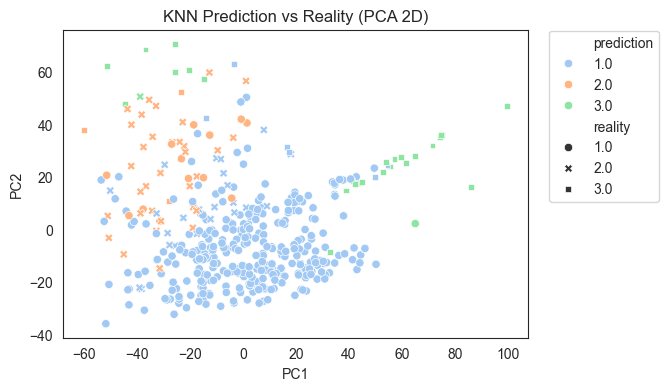

In [65]:

# Convertir les labels en catégoriels ordonnés
labels_test_selected_ordinal = pd.Categorical(labels_test_selected, categories=[1.0, 2.0, 3.0], ordered=True)

# Appliquer la PCA sur les données de test sélectionnées
cls = PCA(n_components=2)
pcs = cls.fit_transform(data_test_selected)

# Assurer que 'prediction' est un array numpy ou une série pandas pour l'utilisation des couleurs
# Exemple : prediction = np.array([0, 1, 2, ...])  # Remplacer par vos données de prédiction

data_transformed = pd.DataFrame(pcs, columns=[0, 1])
data_transformed['prediction'] = prediction
data_transformed['reality'] = labels_test_selected_ordinal

plt.figure(figsize=(6, 4))
# Créer le scatter plot avec Seaborn
fig_KNeighbors = sns.scatterplot(data=data_transformed, x=0, y=1, hue='prediction', style='reality')

# Ajouter les labels pour les axes
#fig_KNeighbors.legend(title=' color = prediction / style = reality')
plt.legend(bbox_to_anchor = (1.03, 1.02), fontsize = 10)
fig_KNeighbors.set_xlabel('PC1')
fig_KNeighbors.set_ylabel('PC2')
fig_KNeighbors.set_title('KNN Prediction vs Reality (PCA 2D)')
# Afficher les figures
#fig_original.show()
plt.show()

In [60]:
data_transformed

,0,1
0,27.446163,-8.160705
1,-25.698341,70.674465
2,-1.085329,5.580488
3,44.468333,-9.609687
4,5.356957,-14.975045
...,...,...
421,2.365650,-14.129650
422,-19.138494,-9.369295
423,-4.170189,11.981333
424,-35.044016,-21.186905


In [55]:
pcs

array([[ 2.74461628e+01, -8.16070520e+00,  6.56618593e+00,
        -1.59721938e+00, -3.28783325e-01, -3.00506023e-04],
       [-2.56983411e+01,  7.06744649e+01,  3.38224978e+01,
         8.75754422e-01,  9.57886972e-01, -6.38068806e-05],
       [-1.08532891e+00,  5.58048830e+00, -1.66765883e+01,
         3.07398573e+00, -3.40440600e-02, -3.02953103e-04],
       ...,
       [-4.17018874e+00,  1.19813334e+01, -3.06313752e+00,
        -2.33695378e+00, -9.87204497e-01, -1.13274252e-04],
       [-3.50440164e+01, -2.11869055e+01, -8.69022179e+00,
        -3.65421419e-01, -1.33888117e+00,  1.95815342e-04],
       [-2.12553625e+01, -2.96931232e+01,  4.81400981e+00,
        -3.96270220e-01, -2.65540392e-01,  1.56908585e-04]])

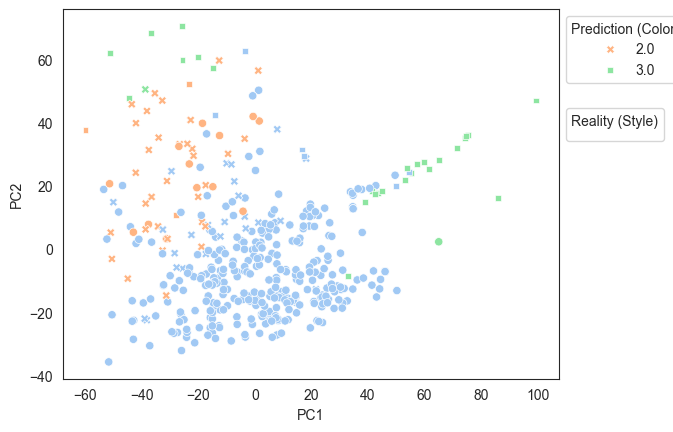

In [47]:
fig, ax = plt.subplots()
scatter = sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=prediction, style=labels_test_selected_ordinal, ax=ax)

# Ajouter les labels pour les axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Personnaliser les légendes
# Séparer les handles and labels pour hue et style
handles, labels = scatter.get_legend_handles_labels()
hue_labels = labels[1:4]  # Assumes 3 classes for hue
hue_handles = handles[1:4]
style_labels = labels[4:]  # Assumes 3 classes for style
style_handles = handles[4:]

# Créer des légendes séparées
legend1 = ax.legend(hue_handles, hue_labels, title="Prediction (Color)", loc="upper left", bbox_to_anchor=(1, 1))
ax.add_artist(legend1)
ax.legend(style_handles, style_labels, title="Reality (Style)", loc="upper left", bbox_to_anchor=(1, 0.75))

plt.show()

<Axes: >

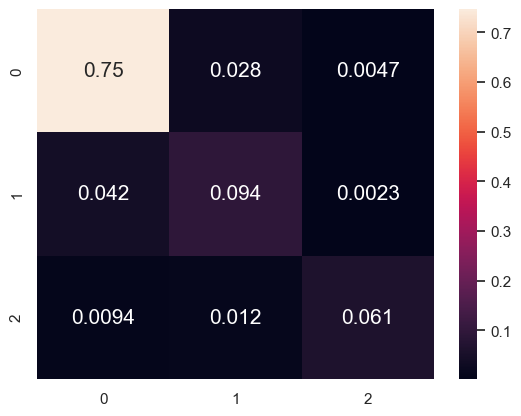

In [ ]:
# matrice de confusion 
cf_matrix = confusion_matrix(labels_test_selected, prediction_selected)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15})

In [ ]:
cf_matrix

array([[318,  12,   2],
       [ 18,  40,   1],
       [  4,   5,  26]], dtype=int64)

In [ ]:
# Test en attribuant des couts

def bayes_decision_rule(y_prob, C):
    # Calculer le risque bayésien pour chaque classe
    R = np.dot(C, y_prob)

    # Classe qui minimise le risque bayésien
    y_pred = np.argmin(R)

    return y_pred+1

# Matrice de couts
C = np.array([[0, 1, 5],  # couts pour un individu sain
              [1, 0, 1],  # couts pour un individu suspect
              [10, 5, 0]])  # couts pour un individu malade

clf_selected_costs = KNeighborsClassifier(n_neighbors=best_n_neighbors)
clf_selected_costs.fit(data_train_selected, labels_train_selected)

y_prob = clf_selected_costs.predict_proba(data_test_selected)

prediction_selected = [bayes_decision_rule(y_prob[i], C) for i in range(len(y_prob))]
prediction_selected = pd.Categorical(prediction_selected, categories=[1.0, 2.0, 3.0], ordered=True)

report_costs = classification_report(labels_test_selected, prediction_selected, target_names=['Normal', 'Suspect', 'Pathologic'])
print(report_costs)
report_costs_dict = classification_report(labels_test_selected, prediction_selected, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)
print("Accuracy pour globale")
print(f"Score données d'entrainements: {clf_selected_costs.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {accuracy_score(labels_test_selected, prediction_selected)}")


print(confusion_matrix(labels_test_selected, prediction_selected))

              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       332
     Suspect       0.65      0.73      0.69        59
  Pathologic       0.93      0.71      0.81        35

    accuracy                           0.90       426
   macro avg       0.84      0.80      0.81       426
weighted avg       0.91      0.90      0.90       426

Accuracy pour globale
Score données d'entrainements: 0.9470588235294117
Score données de test: 0.9014084507042254
[[316  14   2]
 [ 16  43   0]
 [  1   9  25]]


Sensibilité aux pathologiques moins bonne que sans les couts ! (Pourquoi ?)

In [ ]:
cm = confusion_matrix(labels_test_selected, prediction_selected)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'Knn', 
    True, 
    False, 
    True, 
    clf_selected_costs.score(data_train_selected, labels_train_selected), 
    clf_selected_costs.score(data_test_selected, labels_test_selected), 
    report_costs_dict['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429


Le nombre de foetus sains prédits sains et de foetus pathologiques prédits pathologique diminuent. Bien que cette diminution soit très faible (318 à 316 et 26 à 25) On aurait préféré que ce ne soit pas le cas. 

En revanche le nombre de foetus suspects prédits suspects augmente, ce qui est positif.

Surtout,  on divise par 4 le nombre de cas pathologiques prédit comme sains, ce qui était l'objectif principal de l'introduciton d'une matrice de couts

## Analyse discriminante

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [ ]:
models = [
 (LinearDiscriminantAnalysis, "LDA"),
 (QuadraticDiscriminantAnalysis, "QDA"),
 (GaussianNB, "NB")]

def validation_errors(df, models):
   y = df['fetal_health']
   X = df.drop(columns=["fetal_health"])
   for model, name in models:
    for acc in cross_val_score(model(), X, y, cv=10):
        yield name, acc

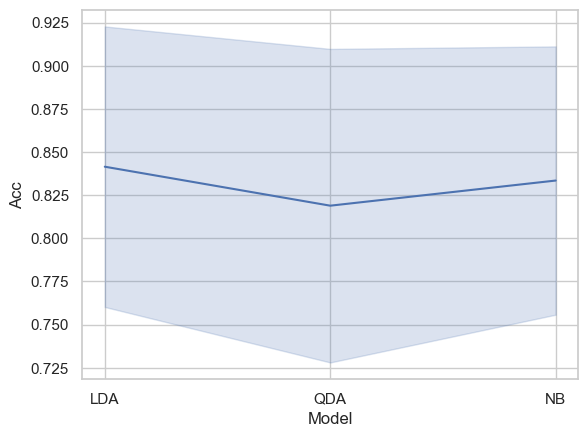

In [ ]:
df = pd.DataFrame(validation_errors(data_selected, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df, errorbar='sd')
plt.show()

In [ ]:
# LDA Données brutes
lda = LinearDiscriminantAnalysis()
lda.fit(data_train, labels_train)
predicted_labels = lda.predict(data_test)
print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {lda.score(data_train, labels_train)}")
print(f"Score données de test: {lda.score(data_test, labels_test)}")


cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'LDA', 
    False, 
    False, 
    False, 
    lda.score(data_train, labels_train), 
    lda.score(data_test, labels_test), 
    classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93       332
     Suspect       0.52      0.56      0.54        59
  Pathologic       0.70      0.54      0.61        35

    accuracy                           0.85       426
   macro avg       0.71      0.68      0.69       426
weighted avg       0.85      0.85      0.85       426

Accuracy pour globale
Score données d'entrainements: 0.888235294117647
Score données de test: 0.8474178403755869


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714


In [ ]:
# LDA Séléction de variables
lda_feature_selection = LinearDiscriminantAnalysis()
lda_feature_selection.fit(data_train_selected, labels_train_selected)
predicted_labels = lda_feature_selection.predict(data_test_selected)

print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {lda_feature_selection.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {lda_feature_selection.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])


accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'LDA', 
    True, 
    False, 
    False, 
    lda_feature_selection.score(data_train_selected, labels_train_selected), 
    lda_feature_selection.score(data_test_selected, labels_test_selected), 
    classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91       332
     Suspect       0.47      0.47      0.47        59
  Pathologic       0.65      0.49      0.56        35

    accuracy                           0.82       426
   macro avg       0.67      0.63      0.65       426
weighted avg       0.82      0.82      0.82       426

Accuracy pour globale
Score données d'entrainements: 0.8605882352941177
Score données de test: 0.823943661971831


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
# LDA Données brutes normalisées
pipeline_standardized_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
pipeline_standardized_lda.fit(data_train, labels_train)
predicted_labels = pipeline_standardized_lda.predict(data_test)

print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_standardized_lda.score(data_train, labels_train)}")
print(f"Score données de test: {pipeline_standardized_lda.score(data_test, labels_test)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'LDA', 
    False, 
    True, 
    False, 
    pipeline_standardized_lda.score(data_train, labels_train), 
    pipeline_standardized_lda.score(data_test, labels_test), 
    classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93       332
     Suspect       0.52      0.56      0.54        59
  Pathologic       0.70      0.54      0.61        35

    accuracy                           0.85       426
   macro avg       0.71      0.68      0.69       426
weighted avg       0.85      0.85      0.85       426

Accuracy pour globale
Score données d'entrainements: 0.888235294117647
Score données de test: 0.8474178403755869


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714


In [ ]:
# LDA Séléction de variables + Normalisation
pipeline_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
pipeline_lda.fit(data_train_selected, labels_train_selected)
predicted_labels = pipeline_lda.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_lda.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {pipeline_lda.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'LDA', 
    True, 
    True, 
    False, 
    pipeline_lda.score(data_train_selected, labels_train_selected), 
    pipeline_lda.score(data_test_selected, labels_test_selected), 
    classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91       332
     Suspect       0.47      0.47      0.47        59
  Pathologic       0.65      0.49      0.56        35

    accuracy                           0.82       426
   macro avg       0.67      0.63      0.65       426
weighted avg       0.82      0.82      0.82       426

Accuracy pour globale
Score données d'entrainements: 0.8605882352941177
Score données de test: 0.823943661971831


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000


In [ ]:
# QDA Données Brutes
qda = QuadraticDiscriminantAnalysis()
qda.fit(data_train, labels_train)
predicted_labels = qda.predict(data_test)
print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {qda.score(data_train, labels_train)}")
print(f"Score données de test: {qda.score(data_test, labels_test)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'QDA', 
    False, 
    False, 
    False, 
    qda.score(data_train, labels_train), qda.score(data_test, labels_test), 
    classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.99      0.70      0.82       332
     Suspect       0.33      0.88      0.48        59
  Pathologic       0.65      0.63      0.64        35

    accuracy                           0.72       426
   macro avg       0.66      0.74      0.65       426
weighted avg       0.87      0.72      0.76       426

Accuracy pour globale
Score données d'entrainements: 0.7305882352941176
Score données de test: 0.7206572769953051


C:\Users\Beziat\PycharmProjects\SY09-Data\.venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000


In [ ]:
# QDA Séléction de variables
qda_feature_selection = QuadraticDiscriminantAnalysis()
qda_feature_selection.fit(data_train_selected, labels_train_selected)
predicted_labels = qda_feature_selection.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {qda_feature_selection.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {qda_feature_selection.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'QDA', 
    True, 
    False, 
    False, 
    qda_feature_selection.score(data_train_selected, labels_train_selected), 
    qda_feature_selection.score(data_test_selected, labels_test_selected), 
    classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.92      0.87      0.89       332
     Suspect       0.44      0.56      0.49        59
  Pathologic       0.56      0.57      0.56        35

    accuracy                           0.80       426
   macro avg       0.64      0.67      0.65       426
weighted avg       0.82      0.80      0.81       426

Accuracy pour globale
Score données d'entrainements: 0.8441176470588235
Score données de test: 0.8028169014084507


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714


In [ ]:
# QDA Données Brutes normalisées
pipeline_standardized_qda = make_pipeline(StandardScaler(),QuadraticDiscriminantAnalysis())
pipeline_standardized_qda.fit(data_train, labels_train)
predicted_labels = pipeline_standardized_qda.predict(data_test)
print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_standardized_qda.score(data_train, labels_train)}")
print(f"Score données de test: {pipeline_standardized_qda.score(data_test, labels_test)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'QDA', 
    False, 
    True, 
    False, 
    pipeline_standardized_qda.score(data_train, labels_train), 
    pipeline_standardized_qda.score(data_test, labels_test), 
    classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

C:\Users\Beziat\PycharmProjects\SY09-Data\.venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



              precision    recall  f1-score   support

      Normal       0.99      0.58      0.74       332
     Suspect       0.28      0.97      0.44        59
  Pathologic       0.75      0.60      0.67        35

    accuracy                           0.64       426
   macro avg       0.68      0.72      0.61       426
weighted avg       0.88      0.64      0.69       426

Accuracy pour globale
Score données d'entrainements: 0.6364705882352941
Score données de test: 0.6384976525821596


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# QDA : séléction de variables + Normalisation
pipeline_qda = make_pipeline(StandardScaler(),QuadraticDiscriminantAnalysis())
pipeline_qda.fit(data_train_selected, labels_train_selected)
predicted_labels = pipeline_qda.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_qda.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {pipeline_qda.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'QDA', True, True, False, pipeline_qda.score(data_train_selected, labels_train_selected), pipeline_qda.score(data_test_selected, labels_test_selected), classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.92      0.87      0.89       332
     Suspect       0.44      0.56      0.49        59
  Pathologic       0.56      0.57      0.56        35

    accuracy                           0.80       426
   macro avg       0.64      0.67      0.65       426
weighted avg       0.82      0.80      0.81       426

Accuracy pour globale
Score données d'entrainements: 0.8441176470588235
Score données de test: 0.8028169014084507


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# NB Donées brutes
nb = GaussianNB()
nb.fit(data_train, labels_train)
predicted_labels = nb.predict(data_test)
print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {nb.score(data_train, labels_train)}")
print(f"Score données de test: {nb.score(data_test, labels_test)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'GaussianNB', False, False, False, nb.score(data_train, labels_train), nb.score(data_test, labels_test), classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.95      0.83      0.88       332
     Suspect       0.45      0.76      0.56        59
  Pathologic       0.60      0.60      0.60        35

    accuracy                           0.80       426
   macro avg       0.66      0.73      0.68       426
weighted avg       0.85      0.80      0.82       426

Accuracy pour globale
Score données d'entrainements: 0.8211764705882353
Score données de test: 0.8004694835680751


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# NB Séléction de variables
nb_feature_selection = GaussianNB()
nb_feature_selection.fit(data_train_selected, labels_train_selected)
predicted_labels = nb_feature_selection.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {nb_feature_selection.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {nb_feature_selection.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'GaussianNB', True, False, False, nb_feature_selection.score(data_train_selected, labels_train_selected), nb_feature_selection.score(data_test_selected, labels_test_selected), classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.93      0.89      0.91       332
     Suspect       0.51      0.63      0.56        59
  Pathologic       0.61      0.63      0.62        35

    accuracy                           0.83       426
   macro avg       0.68      0.72      0.70       426
weighted avg       0.85      0.83      0.84       426

Accuracy pour globale
Score données d'entrainements: 0.8552941176470589
Score données de test: 0.8333333333333334


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# NB Donées brutes normalisées
pipeline_standardized_nb = make_pipeline(StandardScaler(),GaussianNB())
pipeline_standardized_nb.fit(data_train, labels_train)
predicted_labels = pipeline_standardized_nb.predict(data_test)
print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_standardized_nb.score(data_train, labels_train)}")
print(f"Score données de test: {pipeline_standardized_nb.score(data_test, labels_test)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'GaussianNB', False, True, False, pipeline_standardized_nb.score(data_train, labels_train), pipeline_standardized_nb.score(data_test, labels_test), classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.99      0.69      0.81       332
     Suspect       0.34      0.92      0.50        59
  Pathologic       0.57      0.60      0.58        35

    accuracy                           0.71       426
   macro avg       0.63      0.74      0.63       426
weighted avg       0.87      0.71      0.75       426

Accuracy pour globale
Score données d'entrainements: 0.7341176470588235
Score données de test: 0.7136150234741784


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# NB Séléction de variables + Normalisation

pipeline_nb = make_pipeline(StandardScaler(),GaussianNB())
pipeline_nb.fit(data_train_selected, labels_train_selected)
predicted_labels = pipeline_nb.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_nb.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {pipeline_nb.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'GaussianNB', True, True, False, pipeline_nb.score(data_train_selected, labels_train_selected), pipeline_nb.score(data_test_selected, labels_test_selected), classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.93      0.88      0.90       332
     Suspect       0.48      0.56      0.52        59
  Pathologic       0.52      0.63      0.57        35

    accuracy                           0.81       426
   macro avg       0.64      0.69      0.66       426
weighted avg       0.83      0.81      0.82       426

Accuracy pour globale
Score données d'entrainements: 0.8523529411764705
Score données de test: 0.8145539906103286


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


Les meilleures résultats sont obtenus avec LDA sans sélection de variables (avec ou sans normalisation).

Avec QDA et NB, la sélection de variable permet d'améliorer les performances, mais pas pour LDA.

La normalisation n'améliore jamais les performances (soit elle les dégrade soit ne change rien)

In [ ]:
def bayes_decision_rule(y_prob, C):

    # Calculer le risque bayésien pour chaque classe
    R = np.dot(C, y_prob)

    # Classe qui minimise le risque bayésien
    y_pred = np.argmin(R)

    return y_pred+1

# Matrice de couts
C = np.array([[0, 1, 5],  # couts pour un individu sain
              [1, 0, 1],  # couts pour un individu suspect
              [10, 5, 0]])  # couts pour un individu malade

lda_costs = LinearDiscriminantAnalysis()
lda_costs.fit(data_train, labels_train)

predicted_labels = lda_costs.predict_proba(data_test)

prediction = [bayes_decision_rule(predicted_labels[i], C) for i in range(len(predicted_labels))]
prediction = pd.Categorical(prediction, categories=[1.0, 2.0, 3.0], ordered=True)


print(classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic']))

print("Accuracy pour globale")
print(f"Score données d'entrainements: {lda_costs.score(data_train, labels_train)}")
print(f"Score données de test: {accuracy_score(labels_test, prediction)}")


print(confusion_matrix(labels_test, prediction))

cm = confusion_matrix(labels_test, prediction)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'LDA', False, False, True, lda_costs.score(data_train, labels_train), accuracy_score(labels_test, prediction), classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe


              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93       332
     Suspect       0.49      0.58      0.53        59
  Pathologic       0.73      0.46      0.56        35

    accuracy                           0.84       426
   macro avg       0.71      0.65      0.67       426
weighted avg       0.85      0.84      0.84       426

Accuracy pour globale
Score données d'entrainements: 0.888235294117647
Score données de test: 0.8427230046948356
[[309  20   3]
 [ 22  34   3]
 [  4  15  16]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


Les résultats ne sont pas du tout aussi bon qu'avec knn. 

Non seulement les éléments diagonaux (bonnes prédictions) sont toutes inférieures, mais le nombre d'individus pathologiques prédits sains et multiplié par 4. 

## Régression logistique

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(max_iter=300)

# Entraînement du modèle
log_reg.fit(data_train, labels_train)

# Prédictions
predicted_labels = log_reg.predict(data_test)

print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Logistic Regression', False, False, False, log_reg.score(data_train, labels_train), log_reg.score(data_test, labels_test), classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.90      0.96      0.93       332
     Suspect       0.61      0.42      0.50        59
  Pathologic       0.85      0.80      0.82        35

    accuracy                           0.87       426
   macro avg       0.79      0.73      0.75       426
weighted avg       0.86      0.87      0.86       426



C:\Users\Beziat\PycharmProjects\SY09-Data\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
pipeline_standardized_log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipeline_standardized_log_reg.fit(data_train, labels_train)

predicted_labels = pipeline_standardized_log_reg.predict(data_test)

print(classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))

print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_standardized_log_reg.score(data_train, labels_train)}")
print(f"Score données de test: {pipeline_standardized_log_reg.score(data_test, labels_test)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Logistic Regression', False, True, False, pipeline_standardized_log_reg.score(data_train, labels_train), pipeline_standardized_log_reg.score(data_test, labels_test), classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.93      0.94      0.93       332
     Suspect       0.61      0.64      0.63        59
  Pathologic       0.82      0.66      0.73        35

    accuracy                           0.88       426
   macro avg       0.79      0.75      0.76       426
weighted avg       0.88      0.88      0.87       426

Accuracy pour globale
Score données d'entrainements: 0.9070588235294118
Score données de test: 0.8755868544600939


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


<Axes: >

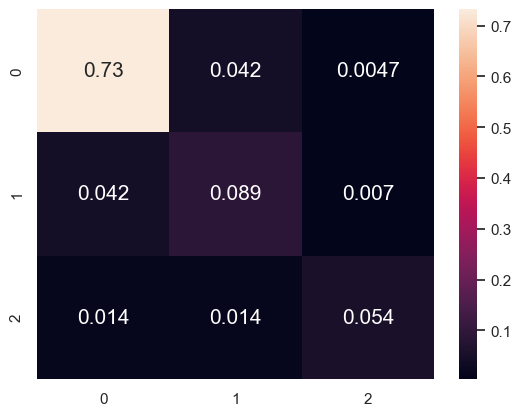

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(labels_test, predicted_labels)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15})

On obtient de moins bons résultats qu'avec knn avec kopt.

Regardons si la selection de variable permet d'améliorer les scores

In [ ]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipeline.fit(data_train_selected, labels_train_selected)

predicted_labels = pipeline.predict(data_test_selected)

print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))

print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {pipeline.score(data_test_selected, labels_test_selected)}")

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'Logistic Regression', 
    True, 
    True, 
    False, 
    pipeline.score(data_train_selected, labels_train_selected), 
    pipeline.score(data_test_selected, labels_test_selected), 
    classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.90      0.94      0.92       332
     Suspect       0.56      0.41      0.47        59
  Pathologic       0.65      0.69      0.67        35

    accuracy                           0.84       426
   macro avg       0.70      0.68      0.68       426
weighted avg       0.83      0.84      0.83       426

Accuracy pour globale
Score données d'entrainements: 0.8741176470588236
Score données de test: 0.8427230046948356


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


Les résultats sont moins bons avec sélection de variables. On reste sur des données brutes normalisées.

In [ ]:
def bayes_decision_rule(y_prob, C):

    # Calculer le risque bayésien pour chaque classe
    R = np.dot(C, y_prob)

    # Classe qui minimise le risque bayésien
    y_pred = np.argmin(R)

    return y_pred+1

# Matrice de couts
C = np.array([[0, 1, 5],  # couts pour un individu sain
              [1, 0, 1],  # couts pour un individu suspect
              [10, 5, 0]])  # couts pour un individu malade

pipeline_costs_log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipeline_costs_log_reg.fit(data_train, labels_train)

predicted_labels = pipeline_costs_log_reg.predict_proba(data_test)

prediction = [bayes_decision_rule(predicted_labels[i], C) for i in range(len(predicted_labels))]
prediction = pd.Categorical(prediction, categories=[1.0, 2.0, 3.0], ordered=True)


print(classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic']))

print("Accuracy pour globale")
print(f"Score données d'entrainements: {pipeline_costs_log_reg.score(data_train, labels_train):.4f}")
print(f"Score données de test: {accuracy_score(labels_test, prediction):.4f}")

print(f"Sensitivity for Pathologic class: {classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")

print(confusion_matrix(labels_test, prediction))

cm = confusion_matrix(labels_test, prediction)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Logistic Regression', False, True, True, pipeline_costs_log_reg.score(data_train, labels_train), accuracy_score(labels_test, prediction), classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe


              precision    recall  f1-score   support

      Normal       0.94      0.93      0.94       332
     Suspect       0.48      0.69      0.57        59
  Pathologic       1.00      0.43      0.60        35

    accuracy                           0.85       426
   macro avg       0.81      0.68      0.70       426
weighted avg       0.89      0.85      0.86       426

Accuracy pour globale
Score données d'entrainements: 0.9071
Score données de test: 0.8545
Sensitivity for Pathologic class: 0.4286 

[[308  24   0]
 [ 18  41   0]
 [  0  20  15]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


Chaque element de la diagonale est inferieur à l'élément correspondant en utilisant les couts et l'algo knn.

Il y a tout de même un point positif : on a aucun cas pathologique prédit sain. 

# Arbres binaires

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
dtc.fit(data_train_selected, labels_train_selected)
predicted_labels = dtc.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))


print(f"Score données d'entrainements: {dtc.score(data_train_selected, labels_train_selected):.4f}")
print(f"Score données de test: {dtc.score(data_test_selected, labels_test_selected):.4f} \n")
print(f"Sensitivity for Pathologic class: {classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")
print(confusion_matrix(labels_test_selected, predicted_labels))

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Decision Tree', True, False, False, dtc.score(data_train_selected, labels_train_selected), dtc.score(data_test_selected, labels_test_selected), classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe


              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       332
     Suspect       0.75      0.78      0.77        59
  Pathologic       0.91      0.89      0.90        35

    accuracy                           0.92       426
   macro avg       0.87      0.87      0.87       426
weighted avg       0.92      0.92      0.92       426

Score données d'entrainements: 0.9994
Score données de test: 0.9225 

Sensitivity for Pathologic class: 0.8857 

[[316  14   2]
 [ 12  46   1]
 [  3   1  31]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy', class_weight=None)
dtc.fit(data_train, labels_train)
predicted_labels = dtc.predict(data_test)
print( classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))
# Print the accuracy scores for the training and test data

print(f"Score données d'entrainements: {dtc.score(data_train, labels_train)}")
print(f"Score données de test: {dtc.score(data_test, labels_test):.4f} \n")
print(f"Sensitivity for Pathologic class: {classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")
print(f"Consusion Matrix : \n {confusion_matrix(labels_test, predicted_labels)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Decision Tree', False, False, False, dtc.score(data_train, labels_train), dtc.score(data_test, labels_test), classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe



              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96       332
     Suspect       0.81      0.78      0.79        59
  Pathologic       0.97      0.89      0.93        35

    accuracy                           0.93       426
   macro avg       0.91      0.88      0.89       426
weighted avg       0.93      0.93      0.93       426

Score données d'entrainements: 1.0
Score données de test: 0.9343 

Sensitivity for Pathologic class: 0.8857 

Consusion Matrix : 
 [[321  10   1]
 [ 13  46   0]
 [  3   1  31]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:

pipeline_decision_tree_selection = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion='entropy', class_weight='balanced'))
pipeline_decision_tree_selection.fit(data_train_selected, labels_train_selected)

predicted_labels = pipeline_decision_tree_selection.predict(data_test_selected)
print(classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))

print(f"Score données d'entrainements: {pipeline_decision_tree_selection.score(data_train_selected, labels_train_selected):.4f}")
print(f"Score données de test: {pipeline_decision_tree_selection.score(data_test_selected, labels_test_selected):.4f} \n")
print(f"Sensitivity for Pathologic class: {classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")
print(confusion_matrix(labels_test_selected, predicted_labels))

cm = confusion_matrix(labels_test_selected, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Decision Tree', True, True, False, pipeline_decision_tree_selection.score(data_train_selected, labels_train_selected), pipeline_decision_tree_selection.score(data_test_selected, labels_test_selected), classification_report(labels_test_selected, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       332
     Suspect       0.73      0.78      0.75        59
  Pathologic       0.91      0.89      0.90        35

    accuracy                           0.92       426
   macro avg       0.87      0.87      0.87       426
weighted avg       0.92      0.92      0.92       426

Score données d'entrainements: 0.9994
Score données de test: 0.9178 

Sensitivity for Pathologic class: 0.8857 

[[314  16   2]
 [ 12  46   1]
 [  3   1  31]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
pipeline_decision_tree = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion='entropy', class_weight=None))
pipeline_decision_tree.fit(data_train, labels_train)

predicted_labels = pipeline_decision_tree.predict(data_test)
print( classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic']))

print(f"Score données d'entrainements: {pipeline_decision_tree.score(data_train, labels_train)}")
print(f"Score données de test: {pipeline_decision_tree.score(data_test, labels_test):.4f} \n")
print(f"Sensitivity for Pathologic class: {classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")
print(f"Consusion Matrix : \n {confusion_matrix(labels_test, predicted_labels)}")

cm = confusion_matrix(labels_test, predicted_labels)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(accuracies_dataframe, 'Decision Tree', False, True, False, pipeline_decision_tree.score(data_train, labels_train), pipeline_decision_tree.score(data_test, labels_test), classification_report(labels_test, predicted_labels, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], patho_predicted_as_patho_or_suspect)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96       332
     Suspect       0.85      0.75      0.79        59
  Pathologic       0.94      0.91      0.93        35

    accuracy                           0.94       426
   macro avg       0.91      0.88      0.89       426
weighted avg       0.94      0.94      0.94       426

Score données d'entrainements: 1.0
Score données de test: 0.9390 

Sensitivity for Pathologic class: 0.9143 

Consusion Matrix : 
 [[324   7   1]
 [ 14  44   1]
 [  2   1  32]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# Test en attribuant des couts

def bayes_decision_rule(y_prob, C):
    # Calculer le risque bayésien pour chaque classe
    R = np.dot(C, y_prob)

    # Classe qui minimise le risque bayésien
    y_pred = np.argmin(R)

    return y_pred+1


# Matrice de couts
C = np.array([[0, 1, 5],  # couts pour un individu sain
              [1, 0, 1],  # couts pour un individu suspect
              [10, 5, 0]])  # couts pour un individu malade

dtc_costs = DecisionTreeClassifier(criterion='entropy', class_weight=None)
dtc_costs.fit(data_train, labels_train)

y_prob = dtc_costs.predict_proba(data_test)
prediction = [bayes_decision_rule(y_prob[i], C) for i in range(len(y_prob))]
prediction = pd.Categorical(prediction, categories=[1.0, 2.0, 3.0], ordered=True)

print(classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic']))


print(f"Score données d'entrainements: {dtc_costs.score(data_train, labels_train):.4f}")
print(f"Score données de test: {accuracy_score(labels_test, prediction)} \n")
print(f"Sensitivity for Pathologic class: {classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")

cm = confusion_matrix(labels_test, prediction)
print(cm)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'Decision Tree', 
    False, 
    False, 
    True, 
    dtc_costs.score(data_train, labels_train), 
    dtc_costs.score(data_test, labels_test), 
    classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96       332
     Suspect       0.87      0.76      0.81        59
  Pathologic       0.91      0.89      0.90        35

    accuracy                           0.94       426
   macro avg       0.91      0.87      0.89       426
weighted avg       0.94      0.94      0.94       426

Score données d'entrainements: 1.0000
Score données de test: 0.9389671361502347 

Sensitivity for Pathologic class: 0.8857 

[[324   6   2]
 [ 13  45   1]
 [  3   1  31]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


In [ ]:
# Test en attribuant des couts

def bayes_decision_rule(y_prob, C):
    # Calculer le risque bayésien pour chaque classe
    R = np.dot(C, y_prob)

    # Classe qui minimise le risque bayésien
    y_pred = np.argmin(R)

    return y_pred+1


# Matrice de couts
C = np.array([[0, 1, 5],  # couts pour un individu sain
              [1, 0, 1],  # couts pour un individu suspect
              [10, 5, 0]])  # couts pour un individu malade

pipeline_decision_tree_costs = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion='entropy', class_weight=None))
pipeline_decision_tree_costs.fit(data_train, labels_train)

y_prob = pipeline_decision_tree_costs.predict_proba(data_test)
prediction = [bayes_decision_rule(y_prob[i], C) for i in range(len(y_prob))]
prediction = pd.Categorical(prediction, categories=[1.0, 2.0, 3.0], ordered=True)

print(classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic']))


print(f"Score données d'entrainements: {pipeline_decision_tree_costs.score(data_train, labels_train):.4f}")
print(f"Score données de test: {accuracy_score(labels_test, prediction)} \n")
print(f"Sensitivity for Pathologic class: {classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall']:.4f} \n")

cm = confusion_matrix(labels_test, prediction)
print(cm)
patho_predicted_as_patho_or_suspect = (cm[2,1]+cm[2,2])/sum(cm[2])

accuracies_dataframe = update_line(
    accuracies_dataframe, 
    'Decision Tree', 
    False, 
    True, 
    True, 
    pipeline_decision_tree_costs.score(data_train, labels_train), 
    pipeline_decision_tree_costs.score(data_test, labels_test), 
    classification_report(labels_test, prediction, target_names=['Normal', 'Suspect', 'Pathologic'], output_dict=True)['Pathologic']['recall'], 
    patho_predicted_as_patho_or_suspect
)
accuracies_dataframe

              precision    recall  f1-score   support

      Normal       0.95      0.96      0.96       332
     Suspect       0.77      0.73      0.75        59
  Pathologic       0.94      0.91      0.93        35

    accuracy                           0.92       426
   macro avg       0.89      0.87      0.88       426
weighted avg       0.92      0.92      0.92       426

Score données d'entrainements: 1.0000
Score données de test: 0.9248826291079812 

Sensitivity for Pathologic class: 0.9143 

[[319  12   1]
 [ 15  43   1]
 [  2   1  32]]


,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
3,LDA,False,False,False,0.888235,0.847418,0.542857,0.885714
4,LDA,True,False,False,0.860588,0.823944,0.485714,0.800000
5,LDA,False,True,False,0.888235,0.847418,0.542857,0.885714
6,LDA,True,True,False,0.860588,0.823944,0.485714,0.800000
7,QDA,False,False,False,0.730588,0.720657,0.628571,1.000000
8,QDA,True,False,False,0.844118,0.802817,0.571429,0.885714
9,QDA,False,True,False,0.636471,0.638498,0.600000,1.000000


Les couts améliorent l'accuracy globale mais pas le recall patholgique => POURQUOI ?

In [ ]:
accuracies_dataframe.sort_values('Acc_test', ascending=False)

,Algorithm,FeatureSelection,Standardization,Costs,Acc_train,Acc_test,Recall_Pathologic,Pathological predicted as Pathological or Suspect
24,Decision Tree,False,False,True,1.000000,0.938967,0.885714,0.914286
23,Decision Tree,False,True,False,1.000000,0.938967,0.914286,0.942857
21,Decision Tree,False,False,False,1.000000,0.934272,0.885714,0.914286
25,Decision Tree,False,True,True,1.000000,0.924883,0.914286,0.942857
20,Decision Tree,True,False,False,0.999412,0.922535,0.885714,0.914286
22,Decision Tree,True,True,False,0.999412,0.917840,0.885714,0.914286
1,Knn,True,False,False,0.947059,0.901408,0.742857,0.885714
2,Knn,True,False,True,0.947059,0.901408,0.714286,0.971429
0,Knn,False,False,False,0.918824,0.884977,0.742857,0.828571
17,Logistic Regression,False,True,False,0.907059,0.875587,0.657143,0.828571
